# Predictive Cluster Models for Crime Victim Analysis:
## A. C. Coffin 
### 11/10/2023
### Northwestern Missouri State University
### MS Data Analytics Capstone
---
## Introduction:
This section demonstrates the use of two clustering algorythms, K-Means and DBSCAN, on Crime Victim Data gathered from the NYPD and the NCVS Dashboard. The objective is to determine which model is the most successful at predictive clustering using both data sets, and then beginning a process of incremental learning. By taking the model trained on the NCVS data and fitting NYPD data, it is possible to exicute a process known as incremental learning. As crime data is extremily complex utilizing incremental learning will address inconcistencies that are common with crime data. 
---
## Importing packages and Addressing Threads:

In [179]:
from threadpoolctl import threadpool_info
from pprint import pprint
import numpy
pprint(threadpool_info())


[{'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\mkl_rt.1.dll',
  'internal_api': 'mkl',
  'num_threads': 6,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2021.4-Product'},
 {'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\libiomp5md.dll',
  'internal_api': 'openmp',
  'num_threads': 12,
  'prefix': 'libiomp',
  'user_api': 'openmp',
  'version': None},
 {'filepath': 'C:\\Users\\Tower\\anaconda3\\vcomp140.dll',
  'internal_api': 'openmp',
  'num_threads': 1,
  'prefix': 'vcomp',
  'user_api': 'openmp',
  'version': None}]


In [180]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
pprint(threadpool_info())

[{'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\mkl_rt.1.dll',
  'internal_api': 'mkl',
  'num_threads': 6,
  'prefix': 'mkl_rt',
  'threading_layer': 'intel',
  'user_api': 'blas',
  'version': '2021.4-Product'},
 {'filepath': 'C:\\Users\\Tower\\anaconda3\\Library\\bin\\libiomp5md.dll',
  'internal_api': 'openmp',
  'num_threads': 12,
  'prefix': 'libiomp',
  'user_api': 'openmp',
  'version': None},
 {'filepath': 'C:\\Users\\Tower\\anaconda3\\vcomp140.dll',
  'internal_api': 'openmp',
  'num_threads': 1,
  'prefix': 'vcomp',
  'user_api': 'openmp',
  'version': None}]


In [203]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("default")

# Pre-Processing:
All of the data within these crime sets is catagorical in nature and as a result was proceed differently. Part of pre-processing was grouping crime types together, as well as removing those which didn't apply to specific models. When addressing the grouping of data within the NYPD dataset, crimes were coordinated based on the general type of crime and severity. The grouping of key codes is explained in the following table, along with thier offense description. The data pulled from the NCVS pertains to mainly Personal Crimes, such as sexual assault, robbery, aggrivated assault and simple assault. In order to make the data found within the NYPD data to be compatible with the incremental learning to occur, these crimes were once again grouped and sorted based on the types found in the NCVS data. Data pertaining to age groups has already been seperated, with an adjustment made to the NCVS data to group minors together as that data in particular breaks the age groups apart indepth. All null values found within the NYPD data for age have been removed, it was included within analysis to visualize the amount of known data in comparison to the unknown within the filtered set.

## Modifications Made to both NCVS and NYPD Data:
Please see the following charts for the modified ML sets. Each of these set was exported from the SQL server independently and labeled ML for this specific section of the project. Victims with a listed age of N/A were put into class 6 for Age_GM. This is in response to how depending on the crime victim ages are ommited for safety, espcially since the NYPD data has associated case numbers in the original set. 

Modifications to Age Groups within the NCVS data is as follows:
|AGE_GM|NCVS Age Groups|New Range|
|:---|:---|:---|
|1 |12-14, 15-17| >18|
|2 |18-20, 21-24| 18-25|
|3 |25-34, 35-49| 25-49|
|4 |50-64| 50-64|
|5 | 65+ | 65+|
|5 |Unknown| Unknown|

Modifications to NYPD data as NCIC Codes and CT_M:
|NCIC|KY_CD|OFNS_DESC|CT_M|CT_M Meaning
|:---|:---|:---|:---|:---|
|1011 |104, 115, 116, 235|Sex Crimes| 2| Violent Crime Except Simple Assault|
|1201 |105, 107, 109-113, 231, 313, 340-343| Robbery/Fraud| 2| Violent Crime Except Simple Assault|
|1301 |101, 103, 106, 114| Homicide/Aggrivated Assault| 2| Violent Crime Except Simple Assault|
|1313 |344, 578, 230, 355| Simple Assault/Related Crimes| 1| Simple Assault|

Data pertaining to Public or Society Crimes, such as driving under the influence, traffic violations, child abandonment, pocession of a deadly weapon or drug pocessions have been removed from this data. This was done as the NCVS data pulled only pertains to Personal Crimes. This data was utilized both through the initial run of the models and again when being fitted to the selected NCVS model. The only difference is that when the NYPD data was fitted to the NCVS model the NCIC model was used. This was to demonstrate the differences between the sets as a whole. 

---
# NCVS Baseline:
As this Analysis relies heavily on the comparison of National Data to Regional Data to explore crime in america as well as demonstrate a possible application of machine learning, creating a baseline is critical. For this section each of the models has been run three times on the pre-processed NCVS data. There are two major data sets which will be used, the first being the NCVS_RegionalML Data, and the second being the NCVS_AgeSegML. 

## Importing NCVS Data:
All data for each of the sets being analysize has been brought in independently to decrease processing load.


In [182]:
NCVS_AgeSeg = pd.read_csv('Data/ML_PreProcess/NCVS_AgeSegML.csv')
NCVS_Region = pd.read_csv('Data/ML_PreProcess/NCVS_RegionSegML.csv')


In [183]:
NCVS_AgeSeg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 960 entries, 0 to 959
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   rpt_dt   960 non-null    int64
 1   age_gm   960 non-null    int64
 2   ncic     960 non-null    int64
 3   vic_num  960 non-null    int64
dtypes: int64(4)
memory usage: 30.1 KB


In [184]:
NCVS_Region.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432 entries, 0 to 431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   rpt_dt    432 non-null    int64
 1   region_m  432 non-null    int64
 2   ncic      432 non-null    int64
 3   vic_num   432 non-null    int64
dtypes: int64(4)
memory usage: 13.6 KB


In [185]:
# file over view
NCVS_AgeSeg.head(2)

,rpt_dt,age_gm,ncic,vic_num
0,1993,1,1101,47196
1,1994,1,1101,49561


In [186]:
# Dropping rows with NA values in any columns
NCVS_AgeSeg.dropna()

# Creating a scaled df where each value has a mean of 0 and stdev of 1
from sklearn import preprocessing
scaler = StandardScaler()
scaler.fit(NCVS_AgeSeg.drop('age_gm', axis=1))
SC_NCVS_AgeSeg= scaler.transform(NCVS_AgeSeg.drop('age_gm',axis=1))

#Transforming into df
SC_NCVS_AgeSeg = pd.DataFrame(SC_NCVS_AgeSeg, columns = NCVS_AgeSeg.drop('age_gm', axis = 1).columns)

#Review scaled rows of the df
print(SC_NCVS_AgeSeg[:5])

     rpt_dt      ncic   vic_num
0 -1.675247 -1.492819 -0.415364
1 -1.559712 -1.492819 -0.401682
2 -1.444178 -1.492819 -0.467381
3 -1.328644 -1.492819 -0.524113
4 -1.213110 -1.492819 -0.394710


In [187]:
# file over view for Region
NCVS_Region.head(2)

,rpt_dt,region_m,ncic,vic_num
0,1996,2,1101,145675
1,1997,2,1101,210209


In [267]:
# Dropping rows with NA values in any columns
NCVS_Region.dropna()

# Creating a scaled df where each value has a mean of 0 and stdev of 1
scaler = StandardScaler()
scaler.fit(NCVS_Region.drop('region_m', axis=1))
SC_NCVSRegion = scaler.transform(NCVS_Region.drop('region_m', axis=1))

# Transforming into df
SC_NCVSRegion = pd.DataFrame(SC_NCVSRegion, columns= NCVS_Region.drop('region_m', axis=1).columns)

#Review scaled rows of the df
print(SC_NCVSRegion)

       rpt_dt      ncic   vic_num
0   -1.669046 -1.492819 -0.290022
1   -1.540658 -1.492819 -0.023054
2   -1.412270 -1.492819 -0.394465
3   -1.283881 -1.492819 -0.297837
4   -1.155493 -1.492819 -0.627759
..        ...       ...       ...
427  1.155493  0.979663  0.200212
428  1.283881  0.979663  0.339144
429  1.412270  0.979663 -0.051218
430  1.540658  0.979663 -0.060902
431  1.669046  0.979663  0.688522

[432 rows x 3 columns]


## K Nearest Neighbors:
This is a form of supervised learning, that was applied to get a sense of how the data will cluster and respond to clustering. While supervised learning is not typically applied to crime data, in this case it is applicable as one of the objectives was to understand the relationship between age and the types of crime among female victims. 



c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

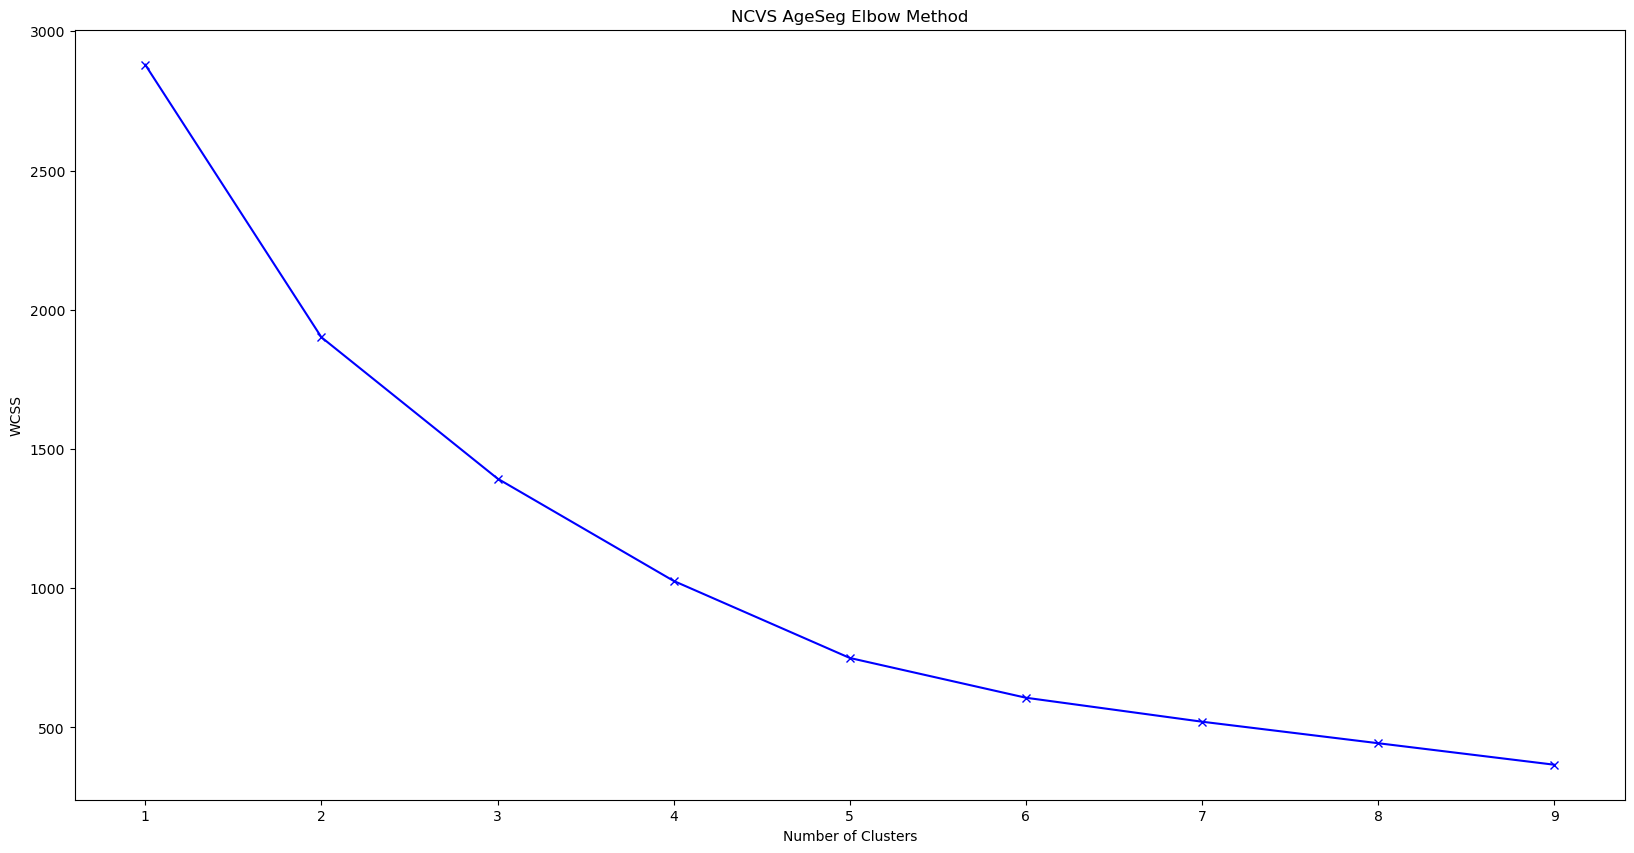

In [189]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

wcss = []
for i in range (1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(SC_NCVS_AgeSeg)
    wcss.append(kmeans.inertia_) # establishing criteria for clustering

plt.plot(range(1, 10), wcss, 'bx-')
plt.title('NCVS AgeSeg Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [190]:
# Creating a split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
X = SC_NCVS_AgeSeg
y = NCVS_AgeSeg['age_gm']

# Creating test split with 20% of data:
X_training_data, X_test_data, y_training_data, y_test_data = train_test_split(X, y, test_size = 0.2)



Based on the graph, the optimal number of clusters is 4, as this is when the slope of the line changes the most. This will be utilized later when running a K-Means Model. While it is not central to a KNN analysis it does serve as a possible guide as to the number to use for K. 

In [258]:
# AgeSeg cluster Analysis:
# Fitting K-Means to the set
# Training the model:
#model = KMeans(n_clusters = 4, init = 'k-means++', random_state=123)
model = KNeighborsClassifier(n_neighbors = 6)
model.fit(X_training_data, y_training_data)

#y_pred = model.fit_predict(y_test_data)
#y_pred

KNeighborsClassifier(n_neighbors=6)

In [259]:
y_train_pred = model.predict(X_training_data)
y_train_pred

array([3, 4, 1, 5, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 2, 3, 1, 3, 3, 3,
       1, 1, 3, 1, 3, 1, 1, 1, 3, 2, 2, 3, 2, 1, 3, 2, 1, 2, 1, 1, 1, 5,
       1, 3, 2, 3, 1, 3, 3, 1, 1, 1, 3, 3, 1, 1, 2, 3, 1, 2, 1, 2, 2, 3,
       1, 1, 1, 1, 3, 3, 5, 3, 1, 4, 3, 1, 1, 2, 1, 3, 1, 3, 1, 3, 3, 3,
       3, 2, 2, 1, 3, 1, 1, 1, 2, 2, 5, 1, 1, 1, 3, 1, 2, 1, 1, 3, 4, 3,
       1, 1, 3, 1, 1, 4, 3, 3, 3, 1, 3, 3, 3, 2, 3, 1, 3, 1, 1, 2, 4, 1,
       1, 1, 3, 1, 2, 1, 5, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 3, 3, 4, 3,
       1, 4, 2, 3, 5, 3, 1, 5, 2, 2, 2, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
       1, 5, 2, 3, 1, 3, 1, 4, 1, 3, 2, 3, 2, 4, 5, 1, 1, 1, 1, 2, 1, 5,
       2, 1, 3, 1, 1, 3, 1, 2, 3, 5, 2, 1, 1, 1, 1, 2, 1, 1, 2, 4, 1, 1,
       5, 3, 4, 4, 1, 3, 3, 2, 1, 2, 2, 3, 2, 2, 2, 1, 1, 1, 3, 2, 5, 2,
       2, 3, 1, 3, 2, 1, 3, 1, 2, 2, 1, 3, 3, 1, 2, 2, 2, 3, 2, 2, 3, 1,
       3, 2, 2, 2, 1, 3, 1, 1, 3, 2, 2, 1, 1, 1, 5, 1, 1, 2, 3, 1, 5, 3,
       4, 3, 3, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 3, 4,

In [260]:
y_test_predict = model.predict(X_test_data)
y_test_predict

array([4, 3, 1, 2, 1, 3, 3, 2, 3, 3, 1, 1, 3, 3, 2, 2, 3, 3, 1, 3, 3, 1,
       3, 2, 3, 1, 5, 4, 2, 1, 3, 2, 2, 1, 2, 1, 1, 2, 2, 3, 1, 3, 2, 1,
       2, 3, 1, 1, 2, 3, 5, 4, 3, 1, 3, 1, 1, 4, 3, 1, 2, 1, 3, 3, 2, 1,
       4, 1, 5, 3, 2, 2, 4, 1, 3, 3, 3, 2, 3, 3, 1, 1, 2, 2, 3, 3, 2, 1,
       4, 1, 2, 2, 3, 1, 2, 1, 1, 5, 1, 1, 3, 1, 1, 4, 5, 2, 1, 1, 2, 2,
       1, 1, 3, 1, 3, 2, 1, 1, 1, 3, 5, 3, 4, 2, 1, 2, 1, 1, 1, 1, 1, 1,
       1, 4, 2, 4, 3, 3, 1, 1, 3, 5, 2, 1, 2, 1, 4, 2, 1, 1, 1, 1, 3, 5,
       1, 1, 1, 1, 2, 1, 1, 3, 3, 3, 2, 3, 3, 5, 3, 1, 1, 2, 2, 4, 1, 1,
       3, 1, 2, 1, 1, 2, 3, 2, 1, 3, 2, 5, 1, 3, 3, 1], dtype=int64)

In [261]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


#Mean Absolute Error:
model_train_mae = mean_absolute_error(y_training_data, y_train_pred)
model_test_mae = mean_absolute_error(y_test_data, y_test_predict)

# Mean Squared Error:
model_train_mse = mean_absolute_error(y_training_data, y_train_pred)
model_test_mse = mean_absolute_error(y_test_data, y_test_predict)

# RMSE
model_train_rmse = np.sqrt(model_train_mse)
model_test_rmse = np.sqrt(model_test_mse)

print(f"KNN Training MAE: {model_train_mae}, KNN Test MAE: {model_test_mae}")
print(f"KNN Training MSE: {model_train_mse}, KNN Test MSE: {model_test_mse}")
print(f"KNN Training RMSE: {model_train_rmse}, KNN Test RMSE: {model_train_rmse}")

KNN Training MAE: 0.8346354166666666, KNN Test MAE: 1.1302083333333333
KNN Training MSE: 0.8346354166666666, KNN Test MSE: 1.1302083333333333
KNN Training RMSE: 0.9135838312200291, KNN Test RMSE: 0.9135838312200291


## Confusion Matrix for NCVS_AgeSeg

## Examining KNN Performance for NCVS AgeSeg:
The performance of KNN on this model was highly dependent on the alteration of K. Initially the model was performed with k=1, and as the data was sifted through the number of k was altered. The reason for this was to determine if there was a connection between the number of clusters that performed the best with KNN, which was developed to examine data clustering based on proximity. As K increases, the model becomes more stable. However, it is important to note that it is easy for this model to over fit.

| Data | Model Type | K Number | MAE | MSE | RMSE |
|:---|:---|:---|:---|:---|:---|
|NCVS_AgeSeg|Training KNN|k=1|0.0|0.0|0.0|
|NCVS_AgeSeg|Test KNN|k=1|1.302|1.302|0|
|NCVS_AgeSeg|Training KNN|k=2|0.694|0.694|0.833|
|NCVS_AgeSeg|Test KNN|k=2|1.151|1.151|0.833|
|NCVS_AgeSeg|Training KNN|k=3|0.755|0.755|0.869|
|NCVS_AgeSeg|Test KNN|k=3|1.078|1.078|0.869|
|NCVS_AgeSeg|Training KNN|k=4|0.768|0.768|0.876|
|NCVS_AgeSeg|Test KNN|k=4|1.182|1.182|0.869|
|NCVS_AgeSeg|Training KNN|k=5|0.784|0.784|0.885|
|NCVS_AgeSeg|Test KNN|k=5|1.192|1.192|0.885|
|NCVS_AgeSeg|Training KNN|k=6|0.835|0.835|0.914|
|NCVS_AgeSeg|Test KNN|k=6|1.130|1.130|0.914|

As this model is not a linear regression but a clustering, the application of R Squared is inappropreate. Instead the focus is on the use of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error. Each of these measures a different aspect of the data, over all the performance does improve as the number of clusters increases on the training set. However when the data is applied with the testing set the model does show to be over fitting as the testing data is significantly higher than the training. This can be observed through the plot bellow that explores Error Rates accross the data. In terms of the k value that performed the best when n_neighbors = 6.

## Error Rates:
Error rates can indicated where a model is failing in terms of KNN. In this instance the error rates tend to be minimized with a K value of 3, which is slightly different when compared to the silhouette analysis performed earlier to establish the number of centroids requried to analysize the data for this model. 

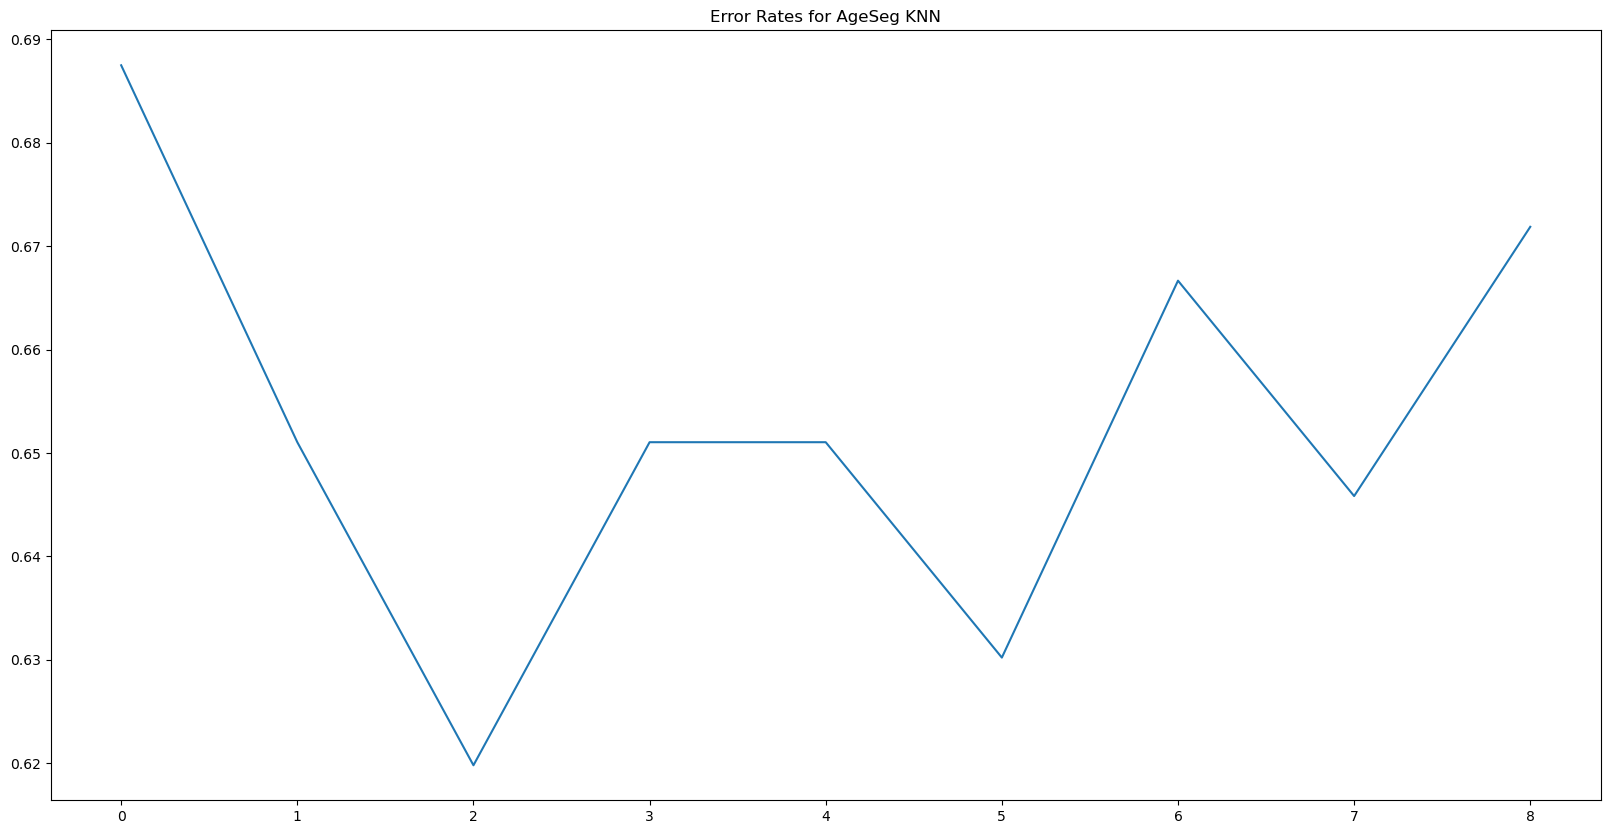

In [262]:
# Error Rates
error_rates=[]

for i in range (1, 10):
    new_mod = KNeighborsClassifier(n_neighbors = i)
    new_mod.fit(X_training_data, y_training_data)
    pred2 = new_mod.predict(X_test_data)
    error_rates.append(np.mean(pred2 != y_test_data))
plt.title("Error Rates for AgeSeg KNN")
plt.plot(error_rates)


# NCVS Regional Data: 
When examining Regional Data the same pipeline was applied, the model has been modified in the cells to run the other data set that represents national data.


In [342]:
# Creating a split
# All splits are 20% test, 80% train
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
X = SC_NCVSRegion
y = NCVS_Region['vic_num']

# Creating test split with 20% of data:
X_training_data, X_test_data, y_training_data, y_test_data = train_test_split(X, y, test_size = 0.2)

# AgeSeg cluster Analysis:
# Training the model:
model2 = KNeighborsClassifier(n_neighbors = 4)
model2.fit(X_training_data, y_training_data)




KNeighborsClassifier(n_neighbors=4)

In [343]:
y_train_pred = model2.predict(X_training_data)
y_train_pred

array([  29389,   29909,   52582,   95470,   18517,  640653,  264179,
        724132,  364810,  217864,   42040,   65449,  102459,  102906,
         72805,   89910,   40566,   28278,   54665,   72398,  546597,
        143026,  186306,  238772,   71815,   61594,  564817,  533965,
         30504,  111921,   79467,  122320,  546597,   81010,   44432,
         52020,   75372,  138163,  640653,   63516,   28278,  101884,
        101884,   10108,   41254,  330768,  519230,   30504,   46885,
        724132, 1114861,  449661,  126031,   34242,  593299,   75372,
         54665,   95596,   83771,   28430,   71270,  360019,  263901,
         56775,  114210,   41685,   70112,   85788,   21200,   62370,
         97487,  217864,  384099,  784350,   43012,  217951,  186306,
        214073,   54665,   28278,  612482,   34128,   34242,  129465,
        471434,   41254,   83515,  112434,  129465,  138163,  402390,
        471434,   63516,  402390,   63690,   72805,   68783,   18517,
         83855,  607

In [344]:
y_test_predict = model.predict(X_test_data)
y_test_predict

array([5, 1, 1, 1, 3, 2, 1, 5, 3, 4, 1, 5, 1, 2, 2, 1, 2, 4, 2, 5, 3, 4,
       2, 1, 1, 1, 3, 1, 1, 2, 2, 1, 2, 2, 1, 3, 1, 2, 1, 1, 2, 2, 1, 3,
       5, 2, 2, 1, 2, 5, 1, 1, 3, 2, 2, 1, 1, 1, 1, 4, 3, 1, 1, 1, 1, 1,
       2, 5, 1, 1, 2, 2, 1, 4, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 3, 1],
      dtype=int64)

In [345]:

#Mean Absolute Error:
model_train_mae = mean_absolute_error(y_training_data, y_train_pred)
model_test_mae = mean_absolute_error(y_test_data, y_test_predict)

# Mean Squared Error:
model_train_mse = mean_absolute_error(y_training_data, y_train_pred)
model_test_mse = mean_absolute_error(y_test_data, y_test_predict)

# RMSE
model_train_rmse = np.sqrt(model_train_mse)
model_test_rmse = np.sqrt(model_test_mse)

print(f"KNN Training MAE: {model_train_mae}, KNN Test MAE: {model_test_mae}")
print(f"KNN Training MSE: {model_train_mse}, KNN Test MSE: {model_test_mse}")
print(f"KNN Training RMSE: {model_train_rmse}, KNN Test RMSE: {model_train_rmse}")

KNN Training MAE: 27460.371014492754, KNN Test MAE: 199378.4712643678
KNN Training MSE: 27460.371014492754, KNN Test MSE: 199378.4712643678
KNN Training RMSE: 165.71171055327608, KNN Test RMSE: 165.71171055327608


## Results of Region KNN
| Data | Model Type | K Number | MAE | MSE | RMSE |
|:---|:---|:---|:---|:---|:---|
|NCVS_Region|Training KNN|k=1|1.252|1.252|1.119|
|NCVS_Region|Test KNN|k=1|1.345|1.345|1.119|
|NCVS_Region|Training KNN|k=2|0.612|0.612|0.782|
|NCVS_Region|Test KNN|k=2|1.368|1.368|0.782|
|NCVS_Region|Training KNN|k=3|0.805|0.805|0.898|
|NCVS_Region|Test KNN|k=3|1.402|1.402|0.898|

When evaluating the performance of this model in terms of training, it performed better than anticipated. However the results do indicate that the model is overfitting the data. When this is combined with the nature of the data consisting of victims, it is important to note that the data is scaled. Scaling will alter these numbers and was done to make the data more uniform. Generally this model performed well in training, especially when k=3, which is an indication that the model does well with the anticipated data but not new data. 

# Combined Results of AgeSeg and Regional Data:
| Data | Model Type | K Number | MAE | MSE | RMSE |
|:---|:---|:---|:---|:---|:---|
|NCVS_AgeSeg|Training KNN|k=1|0.0|0.0|0.0|
|NCVS_AgeSeg|Test KNN|k=1|1.302|1.302|0|
|NCVS_AgeSeg|Training KNN|k=2|0.694|0.694|0.833|
|NCVS_AgeSeg|Test KNN|k=2|1.151|1.151|0.833|
|NCVS_AgeSeg|Training KNN|k=3|0.755|0.755|0.869|
|NCVS_AgeSeg|Test KNN|k=3|1.078|1.078|0.869|
|NCVS_AgeSeg|Training KNN|k=4|0.768|0.768|0.876|
|NCVS_AgeSeg|Test KNN|k=4|1.182|1.182|0.869|
|NCVS_AgeSeg|Training KNN|k=5|0.784|0.784|0.885|
|NCVS_AgeSeg|Test KNN|k=5|1.192|1.192|0.885|
|NCVS_AgeSeg|Training KNN|k=6|0.835|0.835|0.914|
|NCVS_AgeSeg|Test KNN|k=6|1.130|1.130|0.914|
|NCVS_Region|Training KNN|k=1|1.252|1.252|1.119|
|NCVS_Region|Test KNN|k=1|1.345|1.345|1.119|
|NCVS_Region|Training KNN|k=2|0.612|0.612|0.782|
|NCVS_Region|Test KNN|k=2|1.368|1.368|0.782|
|NCVS_Region|Training KNN|k=3|0.805|0.805|0.898|
|NCVS_Region|Test KNN|k=3|1.402|1.402|0.898|


## K-Means Model:
There are a number of clustering models used for data anlysis, one of these models is the kmeans model. The objective of the model is to assign data points to clusters, based on proximity to a centroid. By doing so it explores the association between data points based on distance calculations between groups. The model opperates under the assumption that the cluster is spherical in nature, equally size and has similar dencities. Analysizing crime statistics as well as conceptualizing the actual precence of crime in US society, clustering is often used. The reason is that crime classifications are based on a group of characteristics that are requried for a crime to be considered one class or another. As this data is based on catagorical structure, as opposed to an interval clustering is possible. It is important to note that while in the case of crime, is that while Offenses do carry an ordinal weight within socity, this weight is difficult to build into a model without adding an extra layer or catagory. 

K-Means has limitations, as it performs poorly when clusters are irregular in size, shape and decnity. As the alogrythem itself is based on distance calculations from a centroid, it can be sensitive to the initial placement of a cluster, and even interpret outliers with greater impact than necessary. This is why the analysis begins with K-Means but has an added layer with DBSCAN. 

# Age Segmentation:

In [355]:

# Creating a different scaler to standardize data:
from sklearn import preprocessing
NCVS_AgeSegSC2 = preprocessing.scale(NCVS_AgeSeg)
NCVS_AgeSegSC2 = pd.DataFrame(NCVS_AgeSegSC2)
NCVS_AgeSegSC2.head()

,0,1,2,3,4
0,-1.675247,-1.233905,-1.492819,-0.415364,-0.227085
1,-1.559712,-1.233905,-1.492819,-0.401682,-0.227085
2,-1.444178,-1.233905,-1.492819,-0.467381,-0.227085
3,-1.328644,-1.233905,-1.492819,-0.524113,-0.227085
4,-1.213110,-1.233905,-1.492819,-0.394710,-0.227085


c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Tower\anaconda3\lib\site-packages\sklearn\clust

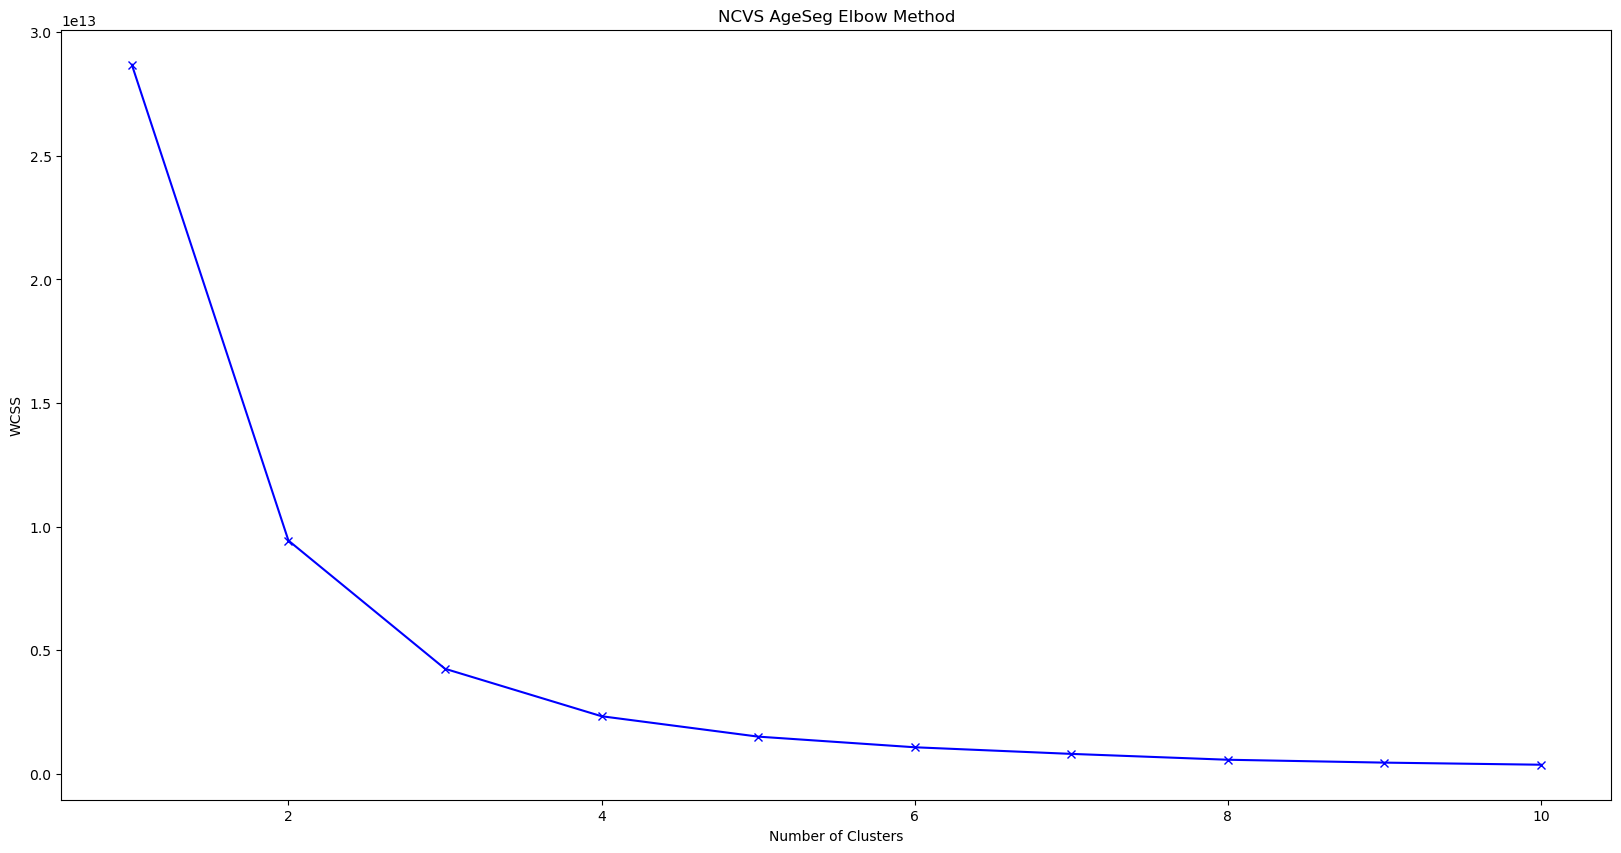

In [346]:
# Estimating the number of clusters using KMeans:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

wcss = []
for i in range (1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 0)
    kmeans.fit(NCVS_AgeSeg)
    wcss.append(kmeans.inertia_) # establishing criteria for clustering

plt.plot(range(1, 11), wcss, 'bx-')
plt.title('NCVS AgeSeg Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

Based on the elbow provided, the number of clusters appropriate to use with this data is 4. 

In [368]:
# Creating the model to analysize the data:
y_kmeansAg = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
y_kmeansAg= y_kmeansAg.fit_predict(NCVS_AgeSegSC2)
y_kmeansAg

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [387]:
cluster = list(y_kmeansAg)
NCVS_AgeSeg['cluster'] = cluster

# mean of clusters 1-4
kmeans_mean_cluster = pd.DataFrame(round(NCVS_AgeSeg.groupby('cluster').mean(),1))
kmeans_mean_cluster

,rpt_dt,age_gm,ncic,vic_num
cluster,,,,
0,2006.2,4.3,1208.9,39357.9
1,2006.0,2.6,1312.8,454376.5
2,2009.8,1.7,1199.6,45853.3
3,2004.2,2.5,1293.2,264843.6


In [388]:
# Creating a Scatter Plot
import matplotlib.pyplot as plt
kmeansAg=KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=1, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()


ValueError: could not convert string to float: 'age_gm'

As noted the data in this case doesn't cluster well as there are too few data instances accross the age groups to perform this type of analysis. Additionally as all of this data is drastic when comparing age groups to the number of victims, when scaling is applied it distorts the data. 